In [1]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns
# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
odf['coords'] = [(lon,lat) for lon,lat in zip(odf['CenLon'],odf['CenLat'])]

In [2]:
fpath = '/home/www/oggm/oggm-standard-projections/oggm-standard-projections-csv-files/1.6.1/common_running_2100_2300/volume'
cmip = 'CMIP6'
endyr = 2300
scenario = 'ssp126'
pd_cmip6_scen = pd.read_csv(f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv', index_col=0)

In [3]:
pd_clim_all = pd.read_csv('../annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', index_col = 'Unnamed: 0')


In [4]:
scenario = 'ssp534-over'
cmip = 'CMIP6'
endyr = 2300


In [5]:
model_ls = {'OGGM':'-', 'PyGEM-OGGM':'--','GloGEM':':' }

In [6]:
gcms_cmip6_2300 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list_2300.csv', index_col=0)  
gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)   

gcms_ssps = []
for ind in gcms_cmip6.loc[gcms_cmip6['var']=='pr'].index:
    gcms_ssps.append(f'{gcms_cmip6.loc[ind].gcm}_{gcms_cmip6.loc[ind].ssp}')
gcm_c = {}
for e,gcm in enumerate(['CanESM5', 'IPSL-CM6A-LR', 'CESM2-WACCM', 'MRI-ESM2-0',
       'ACCESS-CM2', 'ACCESS-ESM1-5']):
    gcm_c[gcm] = f'C{e}'

ssp126 3
CanESM5 0.8 °C
0.8 °C
MRI-ESM2-0 0.7 °C
0.9 °C
IPSL-CM6A-LR 0.6 °C
0.6 °C
ssp534-over 4
CESM2-WACCM 0.2 °C
0.9 °C
CanESM5 1.6 °C
1.6 °C
MRI-ESM2-0 1.1 °C
1.4 °C
IPSL-CM6A-LR 1.0 °C
1.1 °C


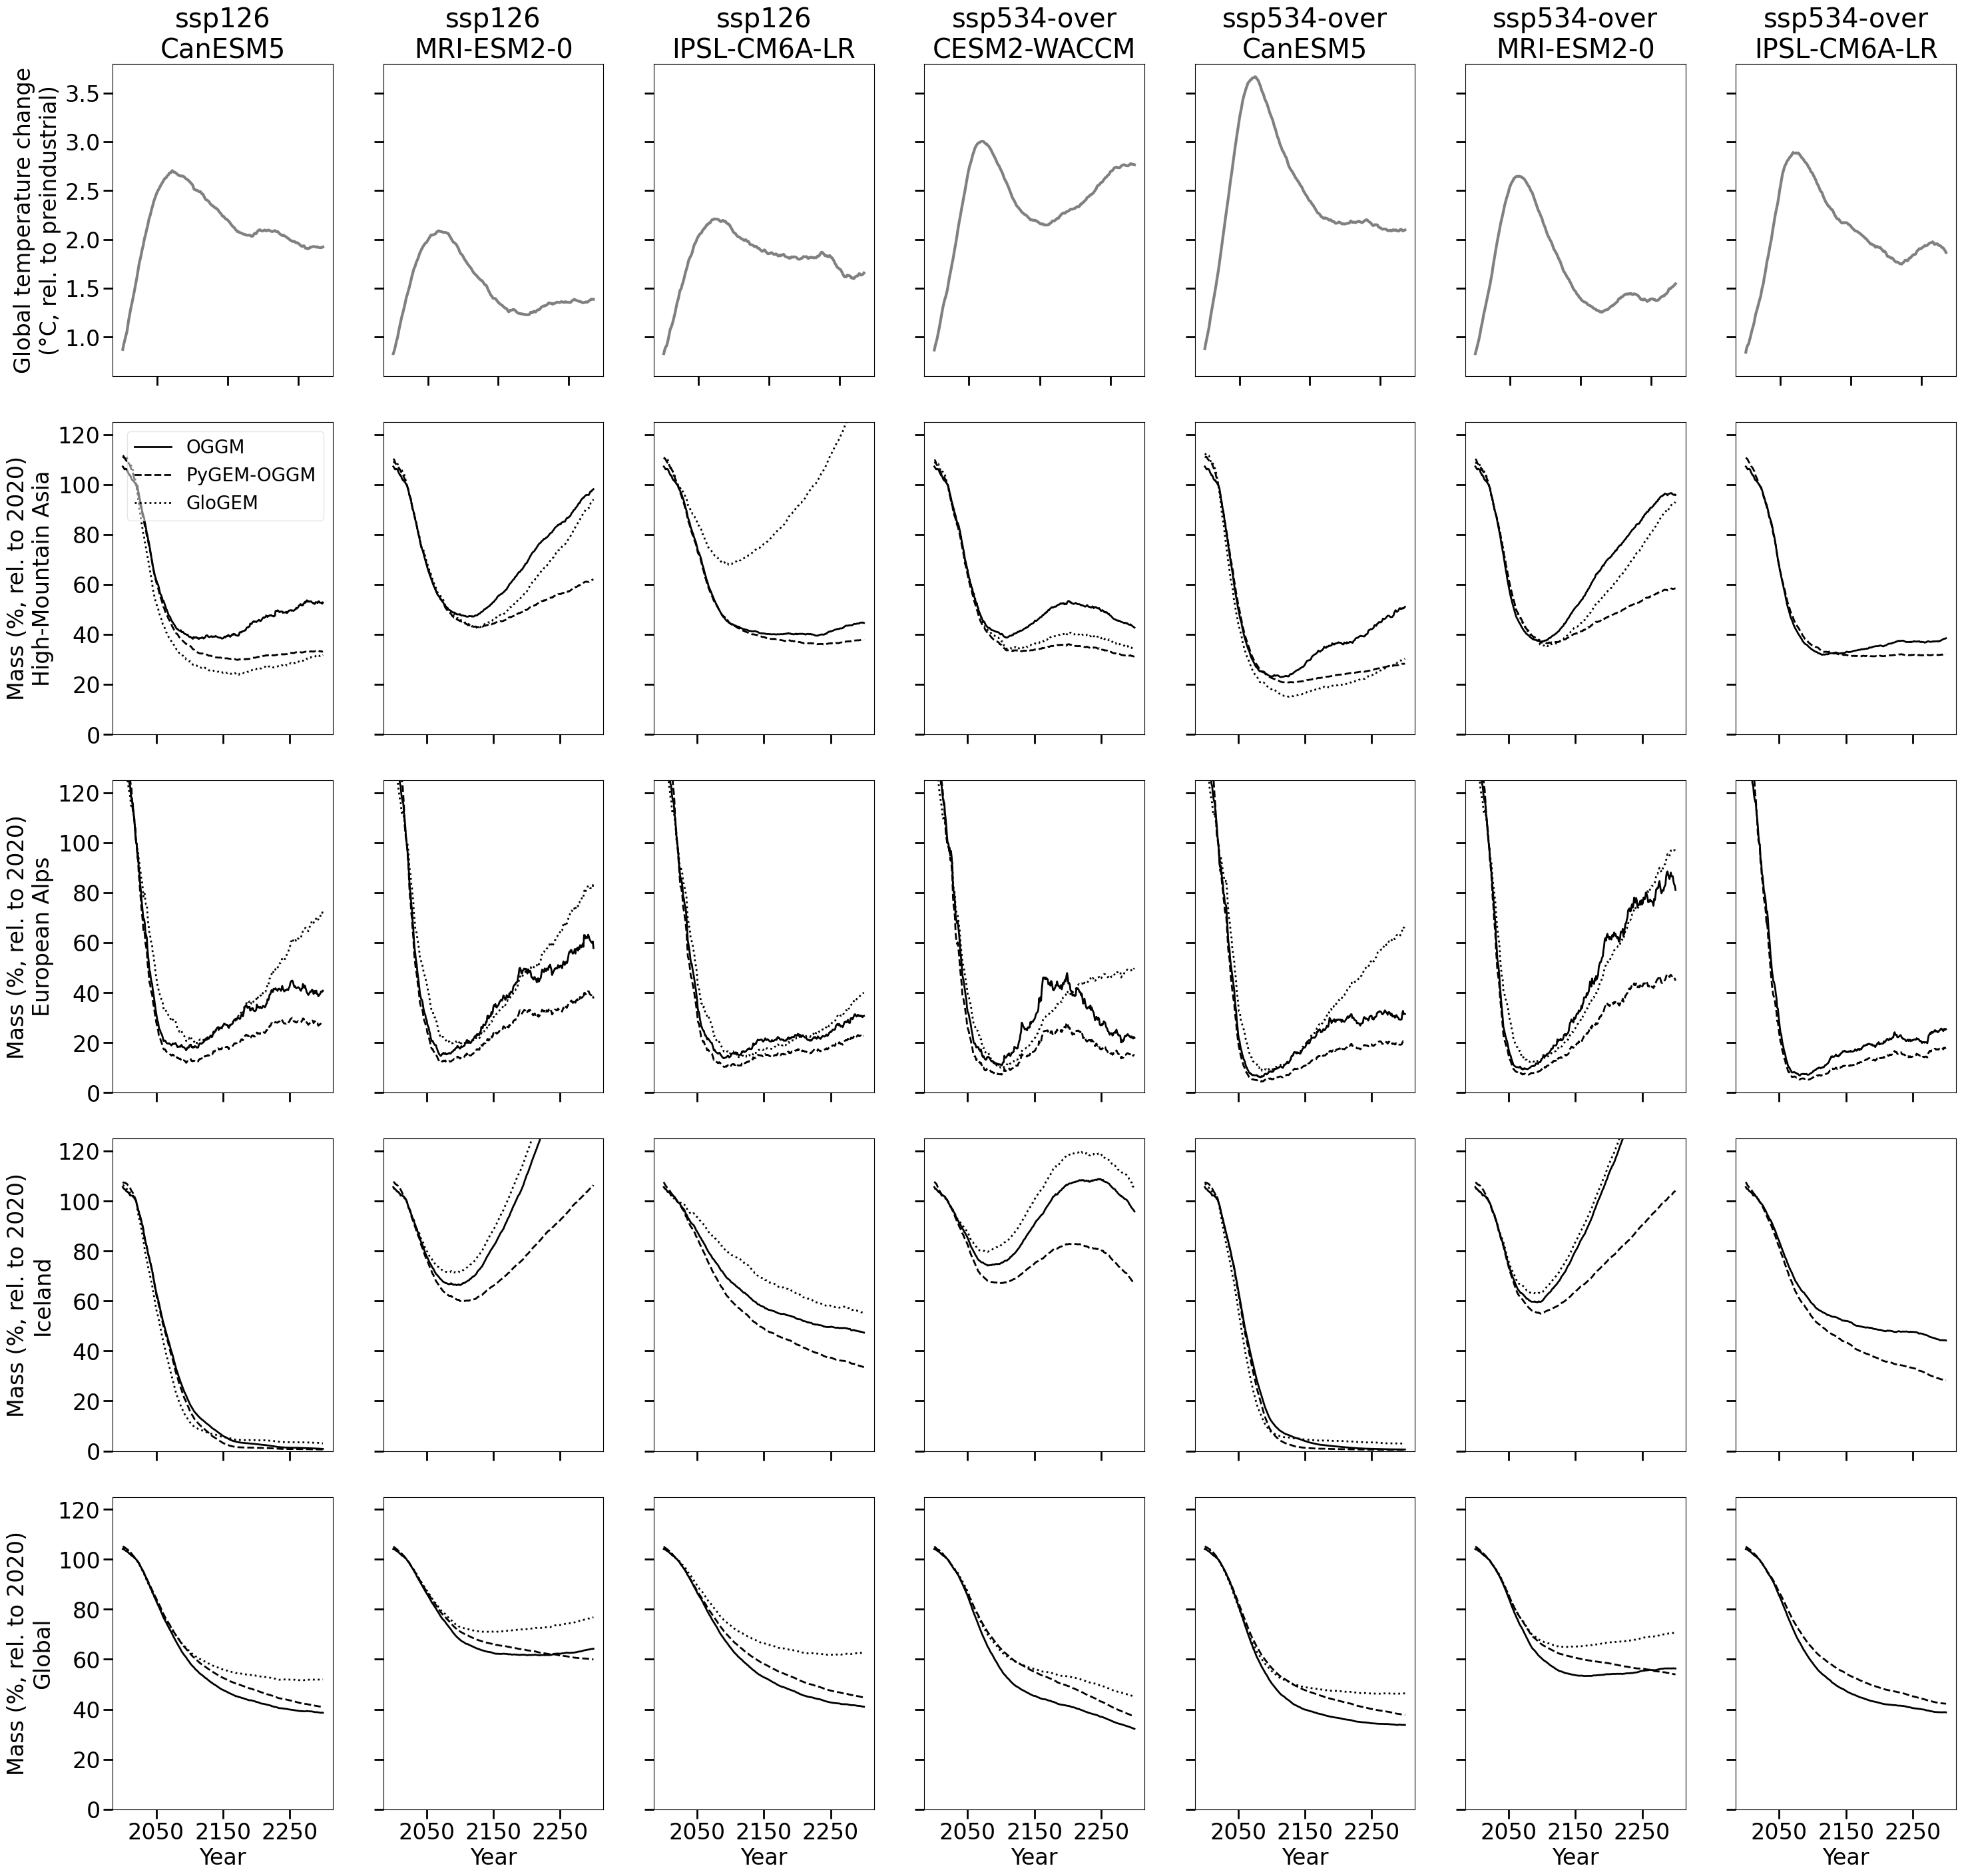

In [25]:

from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 1


plt.rc('font', size=24)

#fig,axs = plt.subplots(2,3,figsize=(24,20))
fig, axs_all = plt.subplots(5,7, figsize=(30,28))

#fig,axs = plt.subplots(2,3,figsize=(24,20))
#fig, axs_all = plt.subplots(4,6, figsize=(35,24))

axs = axs_all[0][:3]

# 'SSP5-3.4-over'

gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]

ssp = 'ssp126'
scenario = ssp
gcms_cmip6_2300_ssp = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
gcm_order = [#'CESM2-WACCM', no overshoot
             'CanESM5',
       'MRI-ESM2-0', 
    'IPSL-CM6A-LR',
    #'ACCESS-ESM1-5', 'ACCESS-CM2' ### no overshoot
            ]

#gcm_order = ['CESM2-WACCM', #no overshoot
#             'CanESM5',
#       'MRI-ESM2-0', 
#    'IPSL-CM6A-LR', 'ACCESS-ESM1-5', 'ACCESS-CM2' ### no overshoot
#            ]

gcms_cmip6_2300_ssp.index = gcms_cmip6_2300_ssp.gcm
gcms_cmip6_2300_ssp = gcms_cmip6_2300_ssp.loc[gcm_order]

print(ssp, len(gcms_cmip6_2300_ssp))

for ax,f in zip(axs,gcms_cmip6_2300_ssp.index):
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_ssp.loc[f]['path'],
                                  use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

    weight = np.cos(np.deg2rad(dtas_annual.lat))
    weight = weight / weight.sum()
    global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
    avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
    avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
    temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + 0.69

    # get the global means for every month:
    global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=31, center=True).mean()
    #color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

    ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + 0.69, 
            color= 'grey', lw=3)
    gcm = gcms_cmip6_2300_ssp.loc[f].gcm
    ax.set_title(ssp+'\n'+gcm)
    ax.set_ylim([0.6,3.8])
    if ax == axs[0]:
        ax.set_ylabel('Global temperature change\n(°C, rel. to preindustrial)')
    ax.set_xlabel('')
    if ax != axs[0]:
        ax.set_yticklabels([])
    ax.set_xticks([2050,2150,2250], ['','',''])

    
    overshoot_deg = global_dtas.max()- global_dtas.dropna(dim='year').isel(year=-1)
    print(gcm, overshoot_deg.values.round(1), '°C')
    temp_overshoot_deg = global_dtas.max()- global_dtas.sel(year=slice('2100','2300')).min()
    print(temp_overshoot_deg.values.round(1), '°C')
    
for region in ['global', 'RGI13-14-15', 'RGI11', 'RGI06']:
    if region == 'global':
        axs = axs_all[4][:3]
    elif region == 'RGI06':
        axs = axs_all[3][:3]
    elif region == 'RGI13-14-15':
        axs = axs_all[1][:3]
    elif region == 'RGI11':
        axs = axs_all[2][:3]
    for model in ['OGGM','PyGEM-OGGM','GloGEM']:
        #if model in ['PyGEM-OGGM','GloGEM']:
        _fpath_other_gmodels = '/home/users/lschuster/glacier-model-projections-until2300/glacier_model_csv_files'
        if region != 'RGI13-14-15':
            fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{region}/{scenario}.csv'
            #else:
            #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
            pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
            pd_cmip_scen = pd_cmip_scen.dropna()
        else:
            pd_cmip_scen = 0
            for sub_region in ['RGI13', 'RGI14', 'RGI15']: 
                fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{sub_region}/{scenario}.csv'
                #else:
                #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
                _pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
                _pd_cmip_scen = _pd_cmip_scen.dropna()
                _pd_cmip_scen.columns = [c.upper() for c in _pd_cmip_scen.columns]
                pd_cmip_scen += _pd_cmip_scen

        pd_cmip_scen.columns = [c.upper() for c in pd_cmip_scen.columns]
        for gcm,ax in zip(gcm_order,axs):
            ax.plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300][gcm.upper()]/pd_cmip_scen.loc[2020][gcm.upper()],
                     ls = model_ls[model], color='black',
                     label=model, lw=2)
        if region == 'RGI13-14-15':
            axs[0].legend(fontsize=20, framealpha = 0.5)
        if region == 'global':
            region_n = 'Global'
        elif region == 'RGI13-14-15':
            region_n = 'High-Mountain Asia'
        elif region == 'RGI11':
            region_n = 'European Alps'
        elif region == 'RGI06':
            region_n = 'Iceland'
            
        for ax in axs:
            if ax == axs[0]:
                ax.set_ylabel(f'Mass (%, rel. to 2020)\n{region_n}')
            ax.set_xlabel('')
            ax.set_ylim([0,125])
            if ax != axs[0]:
                ax.set_yticklabels([])
            ax.set_xticks([2050,2150,2250], ['','',''])
    

##############################################
axs = axs_all[0][3:]
ssp = 'ssp534-over'
scenario = ssp

# 'SSP5-3.4-over'

gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]
gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]

gcm_order = ['CESM2-WACCM', 'CanESM5','MRI-ESM2-0','IPSL-CM6A-LR']
gcms_cmip6_2300_over.index = gcms_cmip6_2300_over.gcm
gcms_cmip6_2300_over = gcms_cmip6_2300_over.loc[gcm_order]

print(ssp, len(gcms_cmip6_2300_over))

for ax,f in zip(axs,gcms_cmip6_2300_over.index):
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                  use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

    weight = np.cos(np.deg2rad(dtas_annual.lat))
    weight = weight / weight.sum()
    global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
    avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
    avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
    temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + 0.69

    # get the global means for every month:
    global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=31, center=True).mean()
    #color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

    ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + 0.69, 
            color= 'grey', lw=3)
    gcm = gcms_cmip6_2300_over.loc[f].gcm
    overshoot_deg = global_dtas.max()- global_dtas.dropna(dim='year').isel(year=-1)
    print(gcm, overshoot_deg.values.round(1), '°C')
    temp_overshoot_deg = global_dtas.max()- global_dtas.sel(year=slice('2100','2300')).min()
    print(temp_overshoot_deg.values.round(1), '°C')

    ax.set_title(ssp+'\n'+gcm)
    ax.set_ylim([0.6,3.8])
    #if ax == axs[0]:
    #    ax.set_ylabel('Global temperature change in °C\n(31-year avg., rel. to preindustrial)')
    #ax.set_xticks([,2100,2200,2300])
    #if ax != axs[0]:
    ax.set_yticklabels([])
    ax.set_xticks([2050,2150,2250], ['','',''])
    ax.set_xlabel('')

for region in ['RGI13-14-15', 'RGI11', 'RGI06', 'global']:
    if region == 'global':
        axs = axs_all[4][3:]
    elif region == 'RGI13-14-15':
        axs = axs_all[1][3:]
    elif region == 'RGI06':
        axs = axs_all[3][3:]
    elif region == 'RGI11':
        axs = axs_all[2][3:]
    for model in ['OGGM','PyGEM-OGGM','GloGEM']:
        #if model in ['PyGEM-OGGM','GloGEM']:
        _fpath_other_gmodels = '/home/users/lschuster/glacier-model-projections-until2300/glacier_model_csv_files'
        if region != 'RGI13-14-15':
            fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{region}/{scenario}.csv'
            #else:
            #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
            pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
            pd_cmip_scen = pd_cmip_scen.dropna()
        else:
            pd_cmip_scen = 0
            for sub_region in ['RGI13', 'RGI14', 'RGI15']: 
                fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{sub_region}/{scenario}.csv'
                #else:
                #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
                _pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
                _pd_cmip_scen = _pd_cmip_scen.dropna()
                _pd_cmip_scen.columns = [c.upper() for c in _pd_cmip_scen.columns]
                pd_cmip_scen += _pd_cmip_scen

        pd_cmip_scen.columns = [c.upper() for c in pd_cmip_scen.columns]
        axs[0].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['CESM2-WACCM']/pd_cmip_scen.loc[2020]['CESM2-WACCM'], ls = model_ls[model], color='black',
                   label=model, lw=2)
        #axs[0].set_title('CESM2-WACCM')
        axs[1].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['CANESM5']/pd_cmip_scen.loc[2020]['CANESM5'], ls = model_ls[model], color='black',
                   lw=2)
        #axs[1].set_title('CanESM5')
        axs[2].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['MRI-ESM2-0']/pd_cmip_scen.loc[2020]['MRI-ESM2-0'], ls = model_ls[model], color='black',
                   lw=2)
        #axs[2].set_title('MRI-ESM2-0')
        if model != 'GloGEM':
            axs[3].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['IPSL-CM6A-LR']/pd_cmip_scen.loc[2020]['IPSL-CM6A-LR'], ls = model_ls[model], color='black', 
                       lw=2)
            #axs[3].set_title('IPSL-CM6A-LR')
        #axs[0].legend()
        if region == 'global':
            region_n = 'Global'
        elif region == 'RGI13-14-15':
            region_n = 'High-Mountain Asia'
        elif region == 'RGI11':
            region_n = 'European Alps'
        elif region == 'RGI06':
            region_n = 'Iceland'

        for ax in axs:
            ax.set_xlabel('')
            ax.set_ylim([0,125])
            #if ax != axs[0]:
            ax.set_yticklabels([])
            ax.set_xticks([2050,2150,2250], ['','',''])

plt.tight_layout()
for ax in axs_all[4]:
    ax.set_xlabel('Year')
    ax.set_xticks([2050,2150,2250], [2050,2150,2250])

plt.savefig('figures/4_discussion_cmip6_overshoot_gcms_ssp126_ssp534_over_2300.png')
plt.savefig('figures/4_discussion_cmip6_overshoot_gcms_ssp126_ssp534_over_2300.pdf')

In [21]:
global_dtas.sel(year=slice('2100','2300'))

<xarray.DataArray (year: 201)>
array([288.76123, 288.74292, 288.72083, 288.7107 , 288.6968 , 288.67844,
       288.65924, 288.64285, 288.6373 , 288.62845, 288.60712, 288.5876 ,
       288.57135, 288.5563 , 288.53845, 288.5249 , 288.51663, 288.5019 ,
       288.4903 , 288.48795, 288.47916, 288.4668 , 288.45746, 288.45642,
       288.44778, 288.43405, 288.4169 , 288.39935, 288.3903 , 288.37497,
       288.36545, 288.35825, 288.35834, 288.3562 , 288.34192, 288.33456,
       288.32468, 288.31876, 288.31677, 288.31924, 288.322  , 288.319  ,
       288.32025, 288.3197 , 288.3196 , 288.31592, 288.306  , 288.30096,
       288.29877, 288.29443, 288.28168, 288.27325, 288.26538, 288.25873,
       288.2501 , 288.24603, 288.23584, 288.23517, 288.23315, 288.22998,
       288.225  , 288.21817, 288.21606, 288.20987, 288.20175, 288.19778,
       288.19092, 288.18393, 288.17856, 288.17343, 288.16306, 288.15784,
       288.1556 , 288.1456 , 288.1336 , 288.12695, 288.1194 , 288.11108,
       288.10178, 288.10178, 288.1007 , 288.09143, 288.0893 , 288.08902,
       288.07776, 288.06772, 288.07236, 288.0782 , 288.0743 , 288.06998,
       288.0649 , 288.06747, 288.0645 , 288.05273, 288.04434, 288.03958,
       288.0263 , 288.02396, 288.0286 , 288.01862, 288.0063 , 287.9886 ,
       287.97556, 287.97452, 287.97122, 287.9689 , 287.9598 , 287.95923,
       287.95657, 287.95804, 287.94894, 287.9368 , 287.92883, 287.92227,
       287.91702, 287.91724, 287.91608, 287.91455, 287.9087 , 287.9015 ,
       287.8998 , 287.89764, 287.89557, 287.90262, 287.90756, 287.91702,
       287.9238 , 287.93573, 287.9358 , 287.93182, 287.93   , 287.93192,
       287.94595, 287.9582 , 287.95874, 287.9623 , 287.9717 , 287.98203,
       287.98618, 287.99283, 287.99292, 287.9955 , 287.99933, 288.01578,
       288.02924, 288.03763, 288.04337, 288.0537 , 288.054  , 288.05212,
       288.05566, 288.06296, 288.06946, 288.07294, 288.08112, 288.08627,
       288.08282, 288.0842 , 288.08612, 288.0931 , 288.09885, 288.10742,
       288.11142, 288.11426, 288.11612, 288.11957, 288.12448, 288.11804,
       288.10236, 288.0978 , 288.10117, 288.103  , 288.10358, 288.10336,
       288.0917 , 288.08627, 288.08612, 288.08545, 288.07703, 288.06714,
       288.0638 , 288.06192, 288.05148, 288.03964, 288.0297 , 288.01465,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan], dtype=float32)
Coordinates:
    height   float64 2.0
  * year     (year) int64 2100 2101 2102 2103 2104 ... 2296 2297 2298 2299 2300

**Check strange GloGEM IPSL behavior**

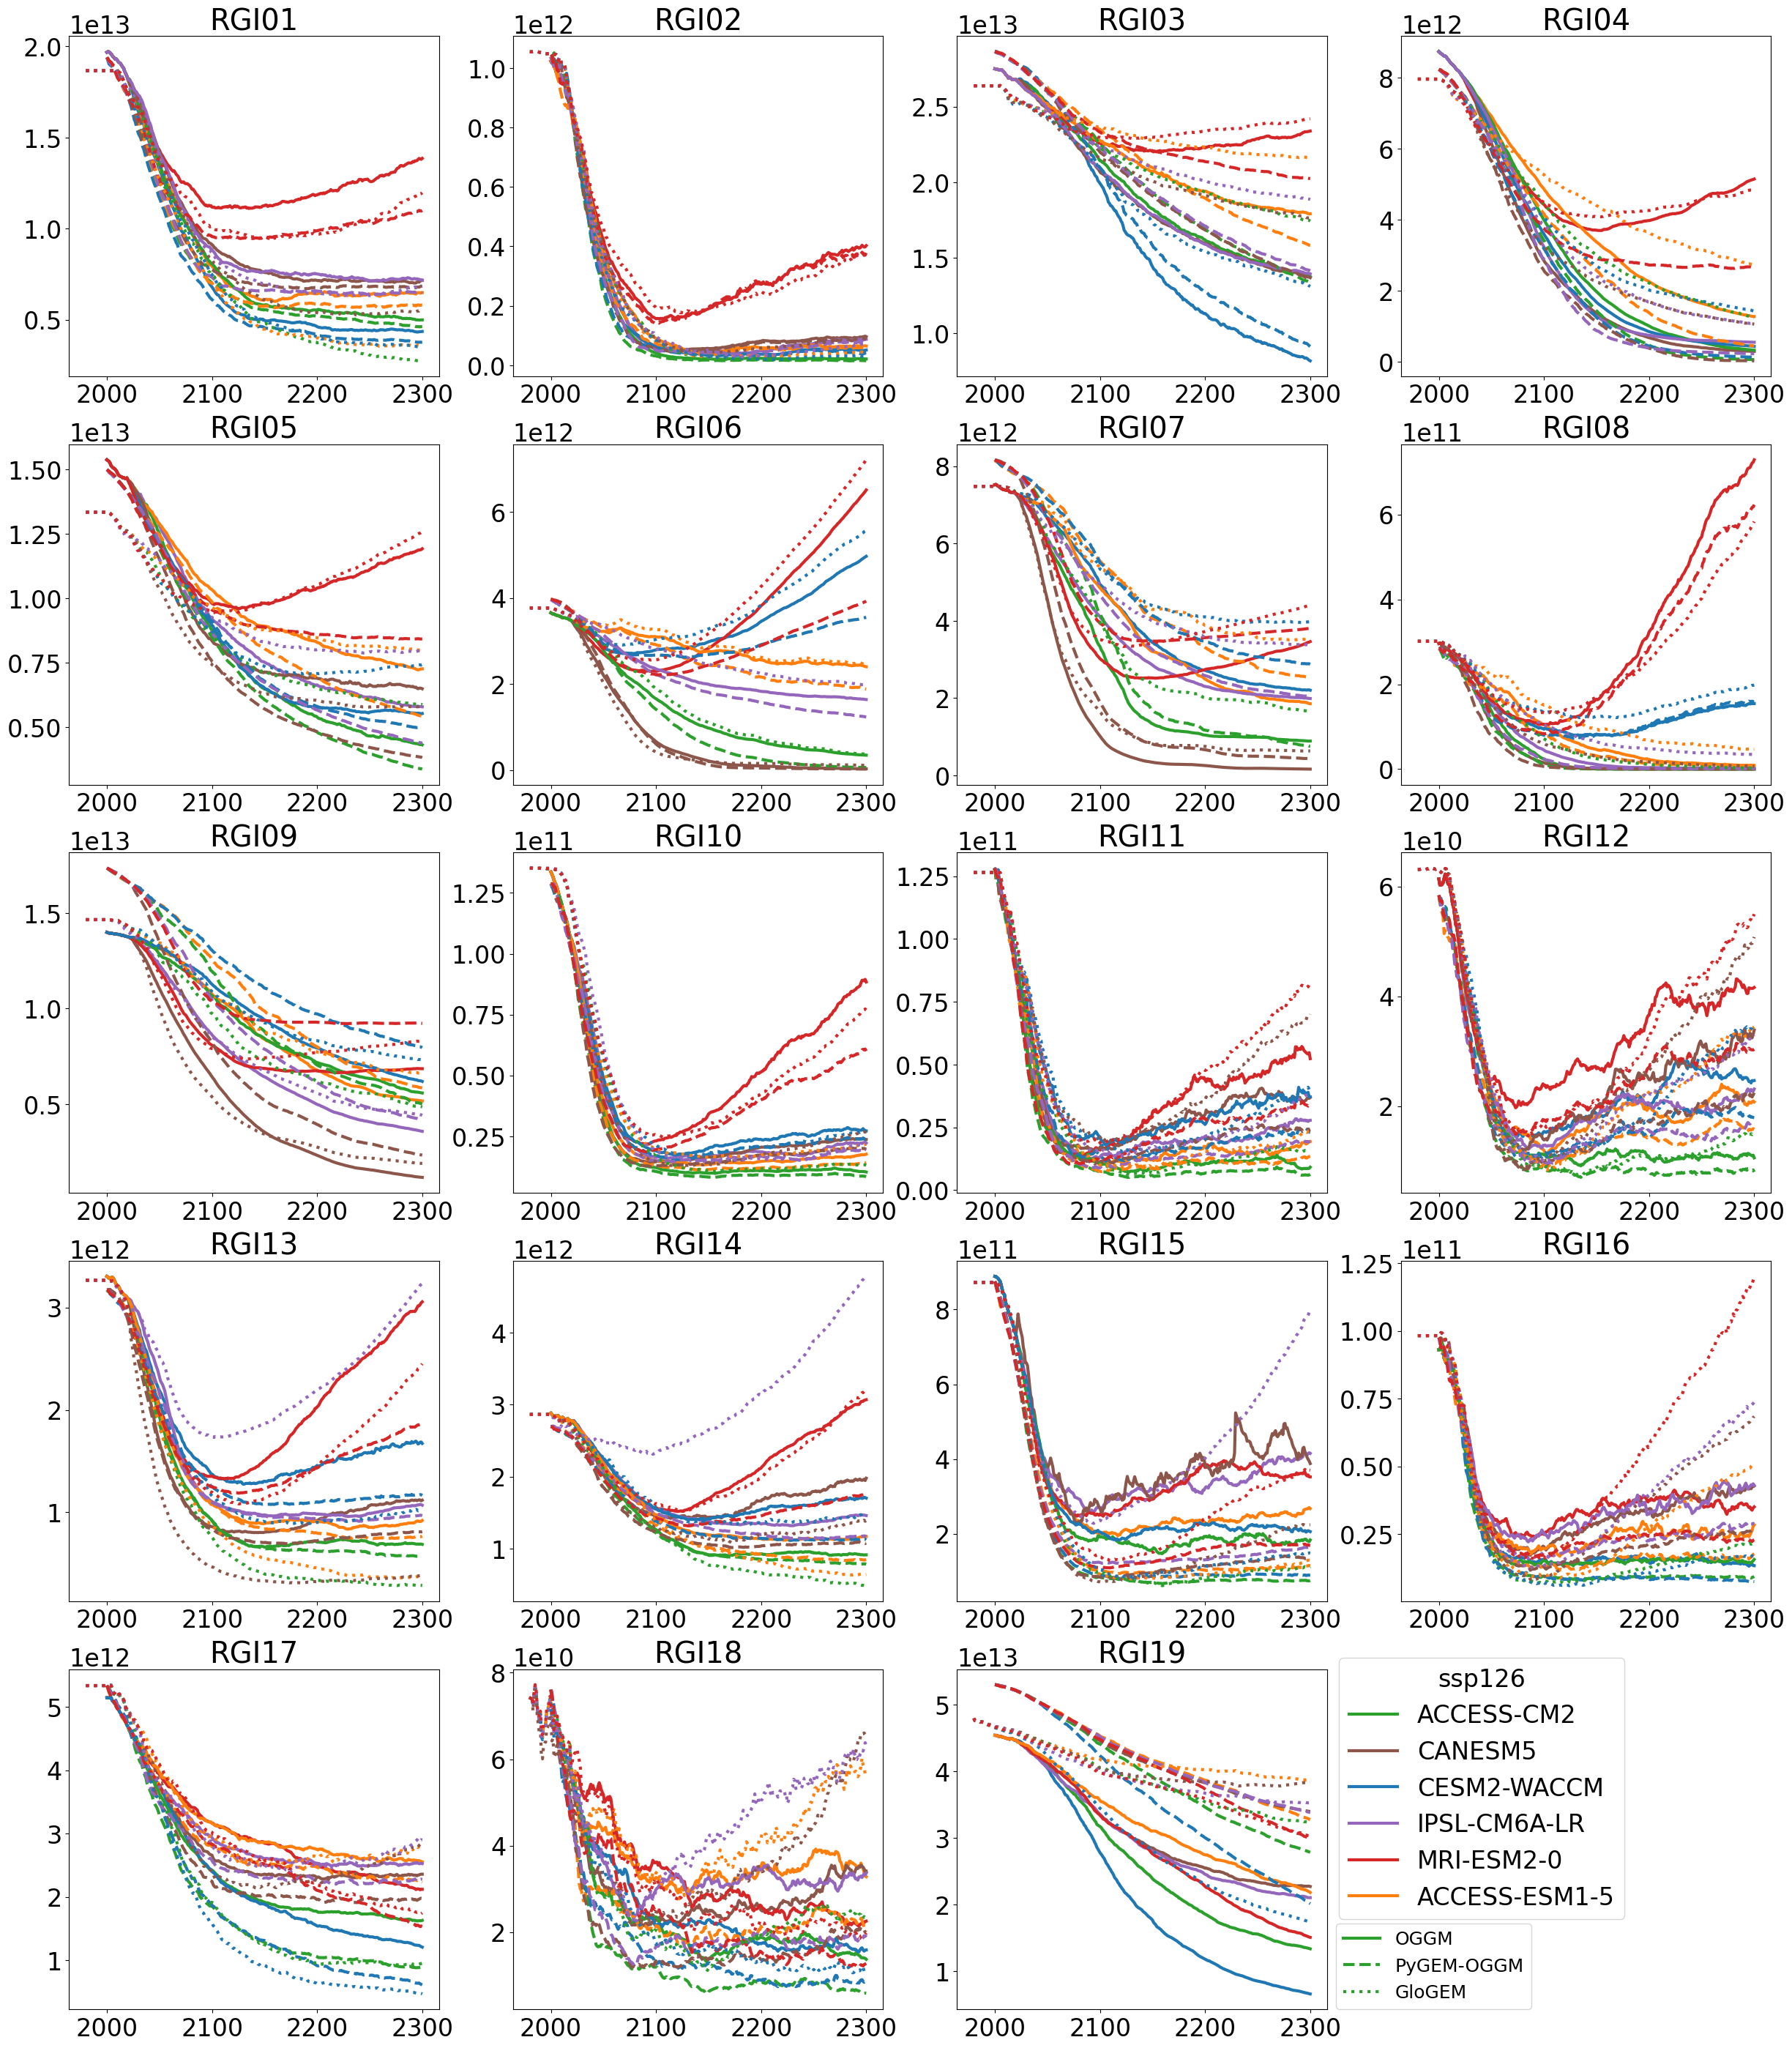

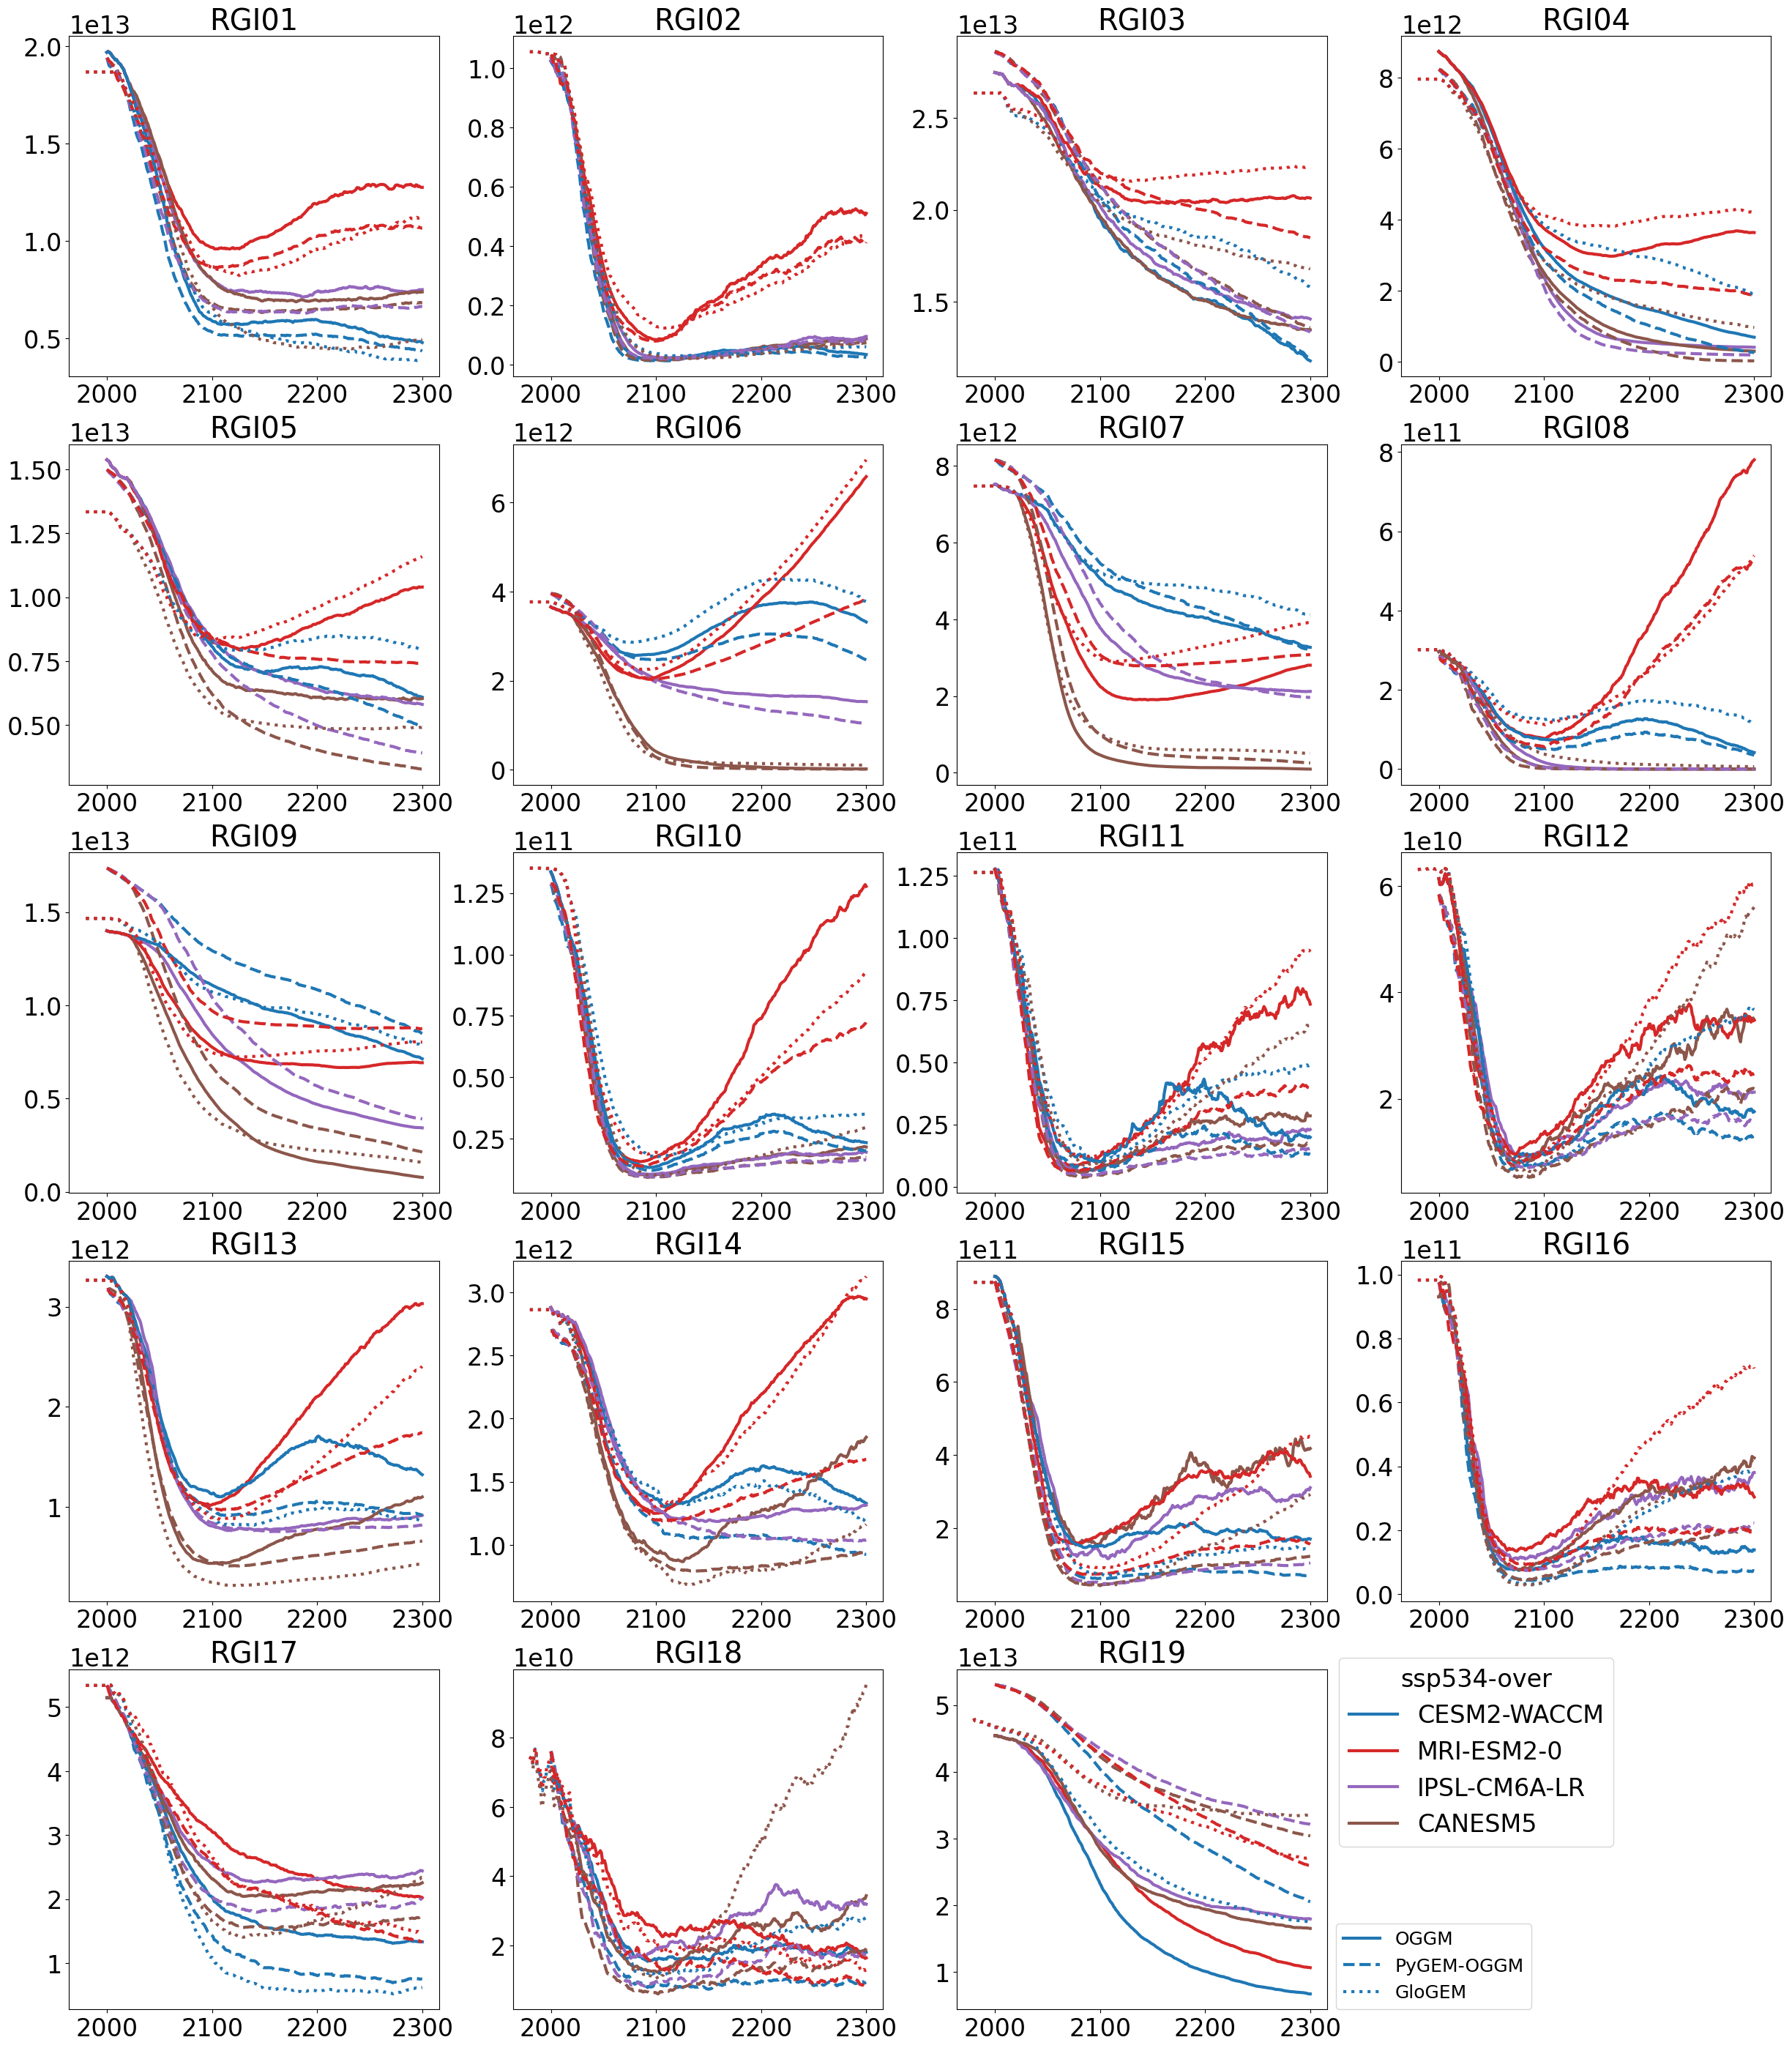

In [9]:
cmip = 'CMIP6'
endyr = 2300
_fpath_other_gmodels = '/home/users/lschuster/glacier-model-projections-until2300/glacier_model_csv_files'
## these are the ssp126 scenarios 
colors_gcm_d = {}
for jj,g in enumerate(['CESM2-WACCM', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'MRI-ESM2-0',  'IPSL-CM6A-LR','CANESM5']):
    colors_gcm_d[g] = f'C{jj}'
gcm_ssp_534_over = ['CESM2-WACCM', 'CanESM5','MRI-ESM2-0','IPSL-CM6A-LR']

for scenario in ['ssp126', 'ssp534-over']:
    if scenario =='ssp126':
        gcms = list(colors_gcm_d.keys())
    else:
        gcms  = gcm_ssp_534_over
    plt.figure(figsize=(30,35))
    j = 1
    for region in ['RGI01','RGI02', 'RGI03',
                   'RGI04','RGI05', 'RGI06',
                   'RGI07','RGI08', 'RGI09',
                   'RGI10','RGI11', 'RGI12',
                   'RGI13','RGI14', 'RGI15',
                  'RGI16','RGI17', 'RGI18','RGI19']:
        plt.subplot(5,4,j)

        for model in ['OGGM','PyGEM-OGGM','GloGEM']:
            fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{region}/{scenario}.csv'
            #else:
            #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
            pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
            pd_cmip_scen = pd_cmip_scen.dropna()

            _pd_cmip_scen.columns = [c.upper() for c in _pd_cmip_scen.columns]

            for gcm in pd_cmip_scen.columns:
                plt.plot(pd_cmip_scen.index, pd_cmip_scen[gcm], label=gcm, lw = 3, ls = model_ls[model], color=colors_gcm_d[gcm.upper()])
        j +=1
        plt.title(region)
        if region == 'RGI19':
            handles, labels = plt.gca().get_legend_handles_labels()
            leg = plt.legend(handles[:len(gcms)], labels[:len(gcms)], 
                       bbox_to_anchor=(1,1.07), loc= 'upper left', title=f'{scenario}')
            plt.legend(handles[::len(gcms)],  ['OGGM','PyGEM-OGGM','GloGEM'], bbox_to_anchor=(1,0.28), loc = 'upper left', fontsize=18)
            plt.gca().add_artist(leg)
    #plt.tight_layout()
    plt.savefig(f'figures/4_busy_plot_all_regions_{scenario}_allmodels.png')

**Only SSP534-over**

ssp534-over 4
CESM2-WACCM 0.2 °C
CanESM5 1.6 °C
MRI-ESM2-0 1.1 °C
IPSL-CM6A-LR 1.0 °C


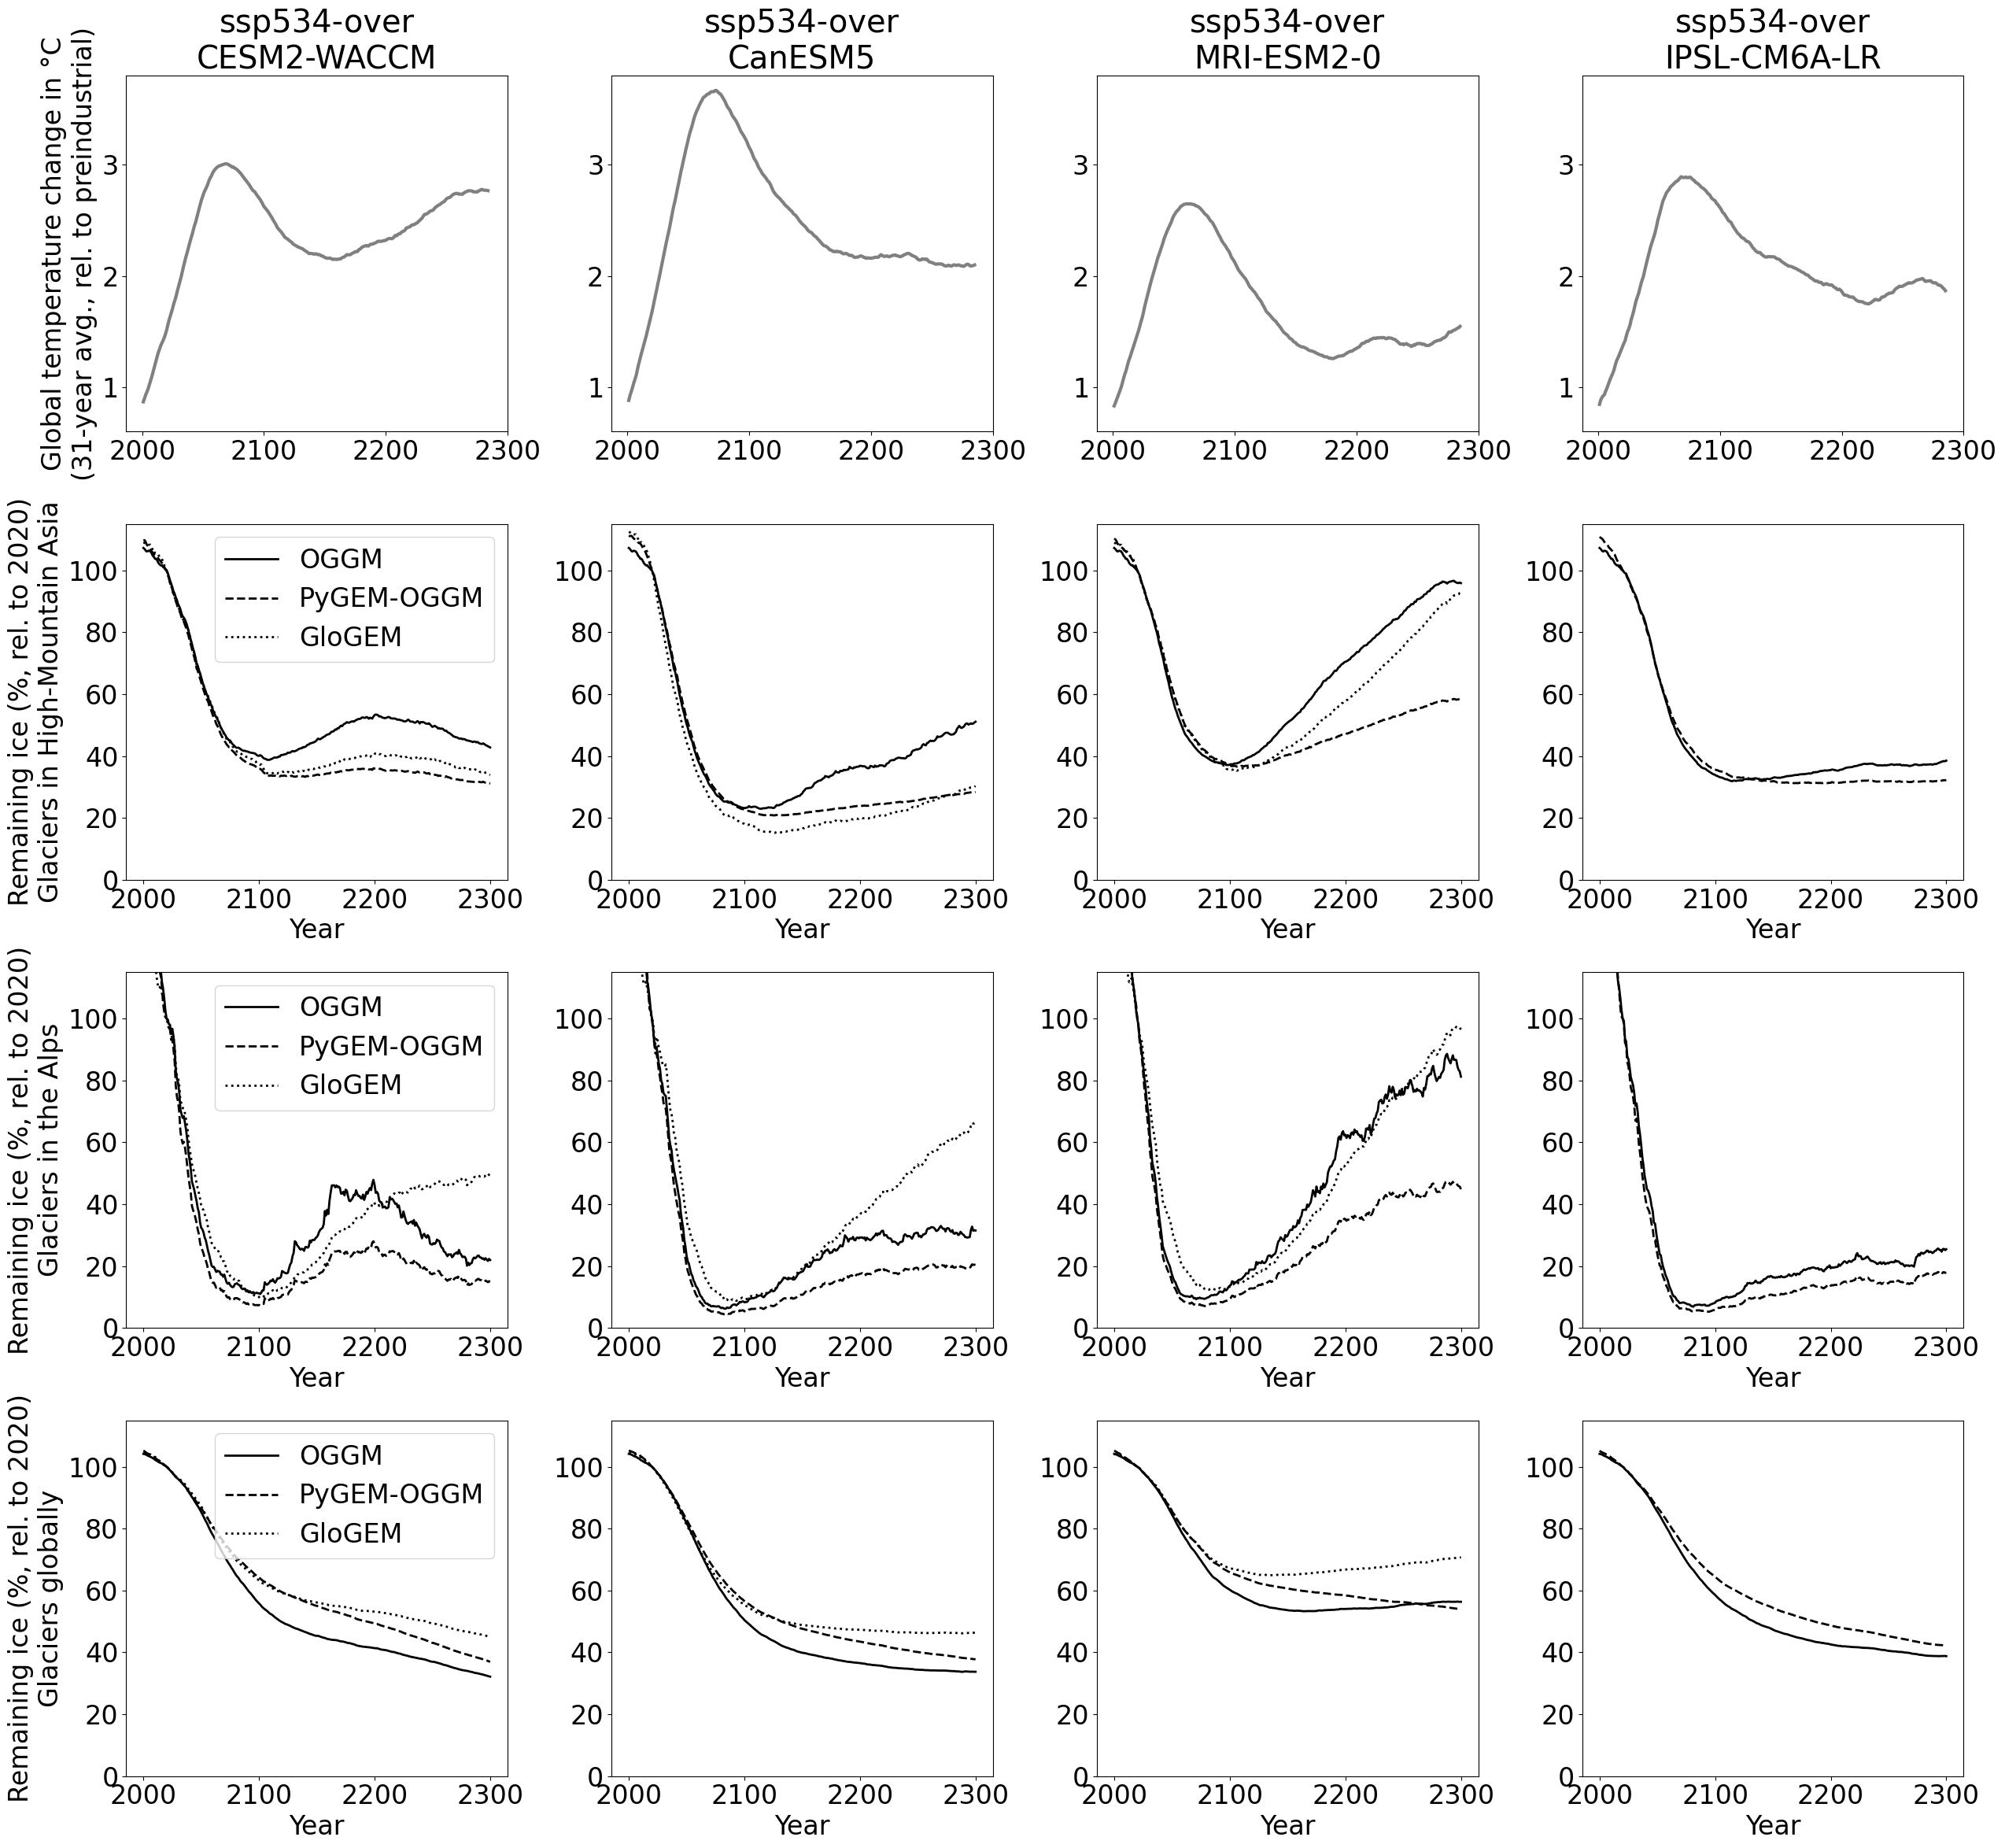

In [10]:

from matplotlib.lines import Line2D

#fig,axs = plt.subplots(2,3,figsize=(24,20))
fig, axs_all = plt.subplots(4,4, figsize=(26,24))

axs = axs_all[0]
plt.rc('font', size=24)
ssp = 'ssp534-over'
scenario = ssp

# 'SSP5-3.4-over'

gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]
gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]

gcm_order = ['CESM2-WACCM', 'CanESM5','MRI-ESM2-0','IPSL-CM6A-LR']
gcms_cmip6_2300_over.index = gcms_cmip6_2300_over.gcm
gcms_cmip6_2300_over = gcms_cmip6_2300_over.loc[gcm_order]

print(ssp, len(gcms_cmip6_2300_over))

for ax,f in zip(axs,gcms_cmip6_2300_over.index):
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                  use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

    weight = np.cos(np.deg2rad(dtas_annual.lat))
    weight = weight / weight.sum()
    global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
    avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
    avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
    temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + 0.69

    # get the global means for every month:
    global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=31, center=True).mean()
    #color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

    ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + 0.69, 
            color= 'grey', lw=3)
    gcm = gcms_cmip6_2300_over.loc[f].gcm
    overshoot_deg = global_dtas.max()- global_dtas.dropna(dim='year').isel(year=-1)
    print(gcm, overshoot_deg.values.round(1), '°C')
    ax.set_title(ssp+'\n'+gcm)
    ax.set_ylim([0.6,3.8])
    if ax == axs[0]:
        ax.set_ylabel('Global temperature change in °C\n(31-year avg., rel. to preindustrial)')
    ax.set_xticks([2000,2100,2200,2300])
for region in ['global', 'RGI13-14-15', 'RGI11']:
    if region == 'global':
        axs = axs_all[3]
    elif region == 'RGI13-14-15':
        axs = axs_all[1]
    elif region == 'RGI11':
        axs = axs_all[2]
    for model in ['OGGM','PyGEM-OGGM','GloGEM']:
        #if model in ['PyGEM-OGGM','GloGEM']:
        _fpath_other_gmodels = '/home/users/lschuster/glacier-model-projections-until2300/glacier_model_csv_files'
        if region != 'RGI13-14-15':
            fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{region}/{scenario}.csv'
            #else:
            #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
            pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
            pd_cmip_scen = pd_cmip_scen.dropna()
        else:
            pd_cmip_scen = 0
            for sub_region in ['RGI13', 'RGI14', 'RGI15']: 
                fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{sub_region}/{scenario}.csv'
                #else:
                #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
                _pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
                _pd_cmip_scen = _pd_cmip_scen.dropna()
                _pd_cmip_scen.columns = [c.upper() for c in _pd_cmip_scen.columns]
                pd_cmip_scen += _pd_cmip_scen

        pd_cmip_scen.columns = [c.upper() for c in pd_cmip_scen.columns]
        axs[0].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['CESM2-WACCM']/pd_cmip_scen.loc[2020]['CESM2-WACCM'], ls = model_ls[model], color='black',
                   label=model, lw=2)
        #axs[0].set_title('CESM2-WACCM')
        axs[1].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['CANESM5']/pd_cmip_scen.loc[2020]['CANESM5'], ls = model_ls[model], color='black',
                   lw=2)
        #axs[1].set_title('CanESM5')
        axs[2].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['MRI-ESM2-0']/pd_cmip_scen.loc[2020]['MRI-ESM2-0'], ls = model_ls[model], color='black',
                   lw=2)
        #axs[2].set_title('MRI-ESM2-0')
        if model != 'GloGEM':
            axs[3].plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300]['IPSL-CM6A-LR']/pd_cmip_scen.loc[2020]['IPSL-CM6A-LR'], ls = model_ls[model], color='black', 
                       lw=2)
            #axs[3].set_title('IPSL-CM6A-LR')
        axs[0].legend()
        if region == 'global':
            region_n = 'Glaciers globally'
        elif region == 'RGI13-14-15':
            region_n = 'Glaciers in High-Mountain Asia'
        elif region == 'RGI11':
            region_n = 'Glaciers in the Alps'

        for ax in axs:
            if ax == axs[0]:
                ax.set_ylabel(f'Remaining ice (%, rel. to 2020)\n{region_n}')
            ax.set_xlabel('Year')
            ax.set_ylim([0,115])
            ax.set_xticks([2000,2100,2200,2300])

plt.tight_layout()
plt.savefig('figures/4_discussion_ssp534_over_2300.png')

In [11]:
gcms_cmip6_sel.gcm.unique()

array(['CESM2-WACCM', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'CanESM5',
       'IPSL-CM6A-LR', 'MRI-ESM2-0'], dtype=object)

**Only SSP126**

ssp126 6
CESM2-WACCM 0.0 °C
CanESM5 0.8 °C
MRI-ESM2-0 0.7 °C
IPSL-CM6A-LR 0.6 °C
ACCESS-ESM1-5 0.2 °C
ACCESS-CM2 0.0 °C


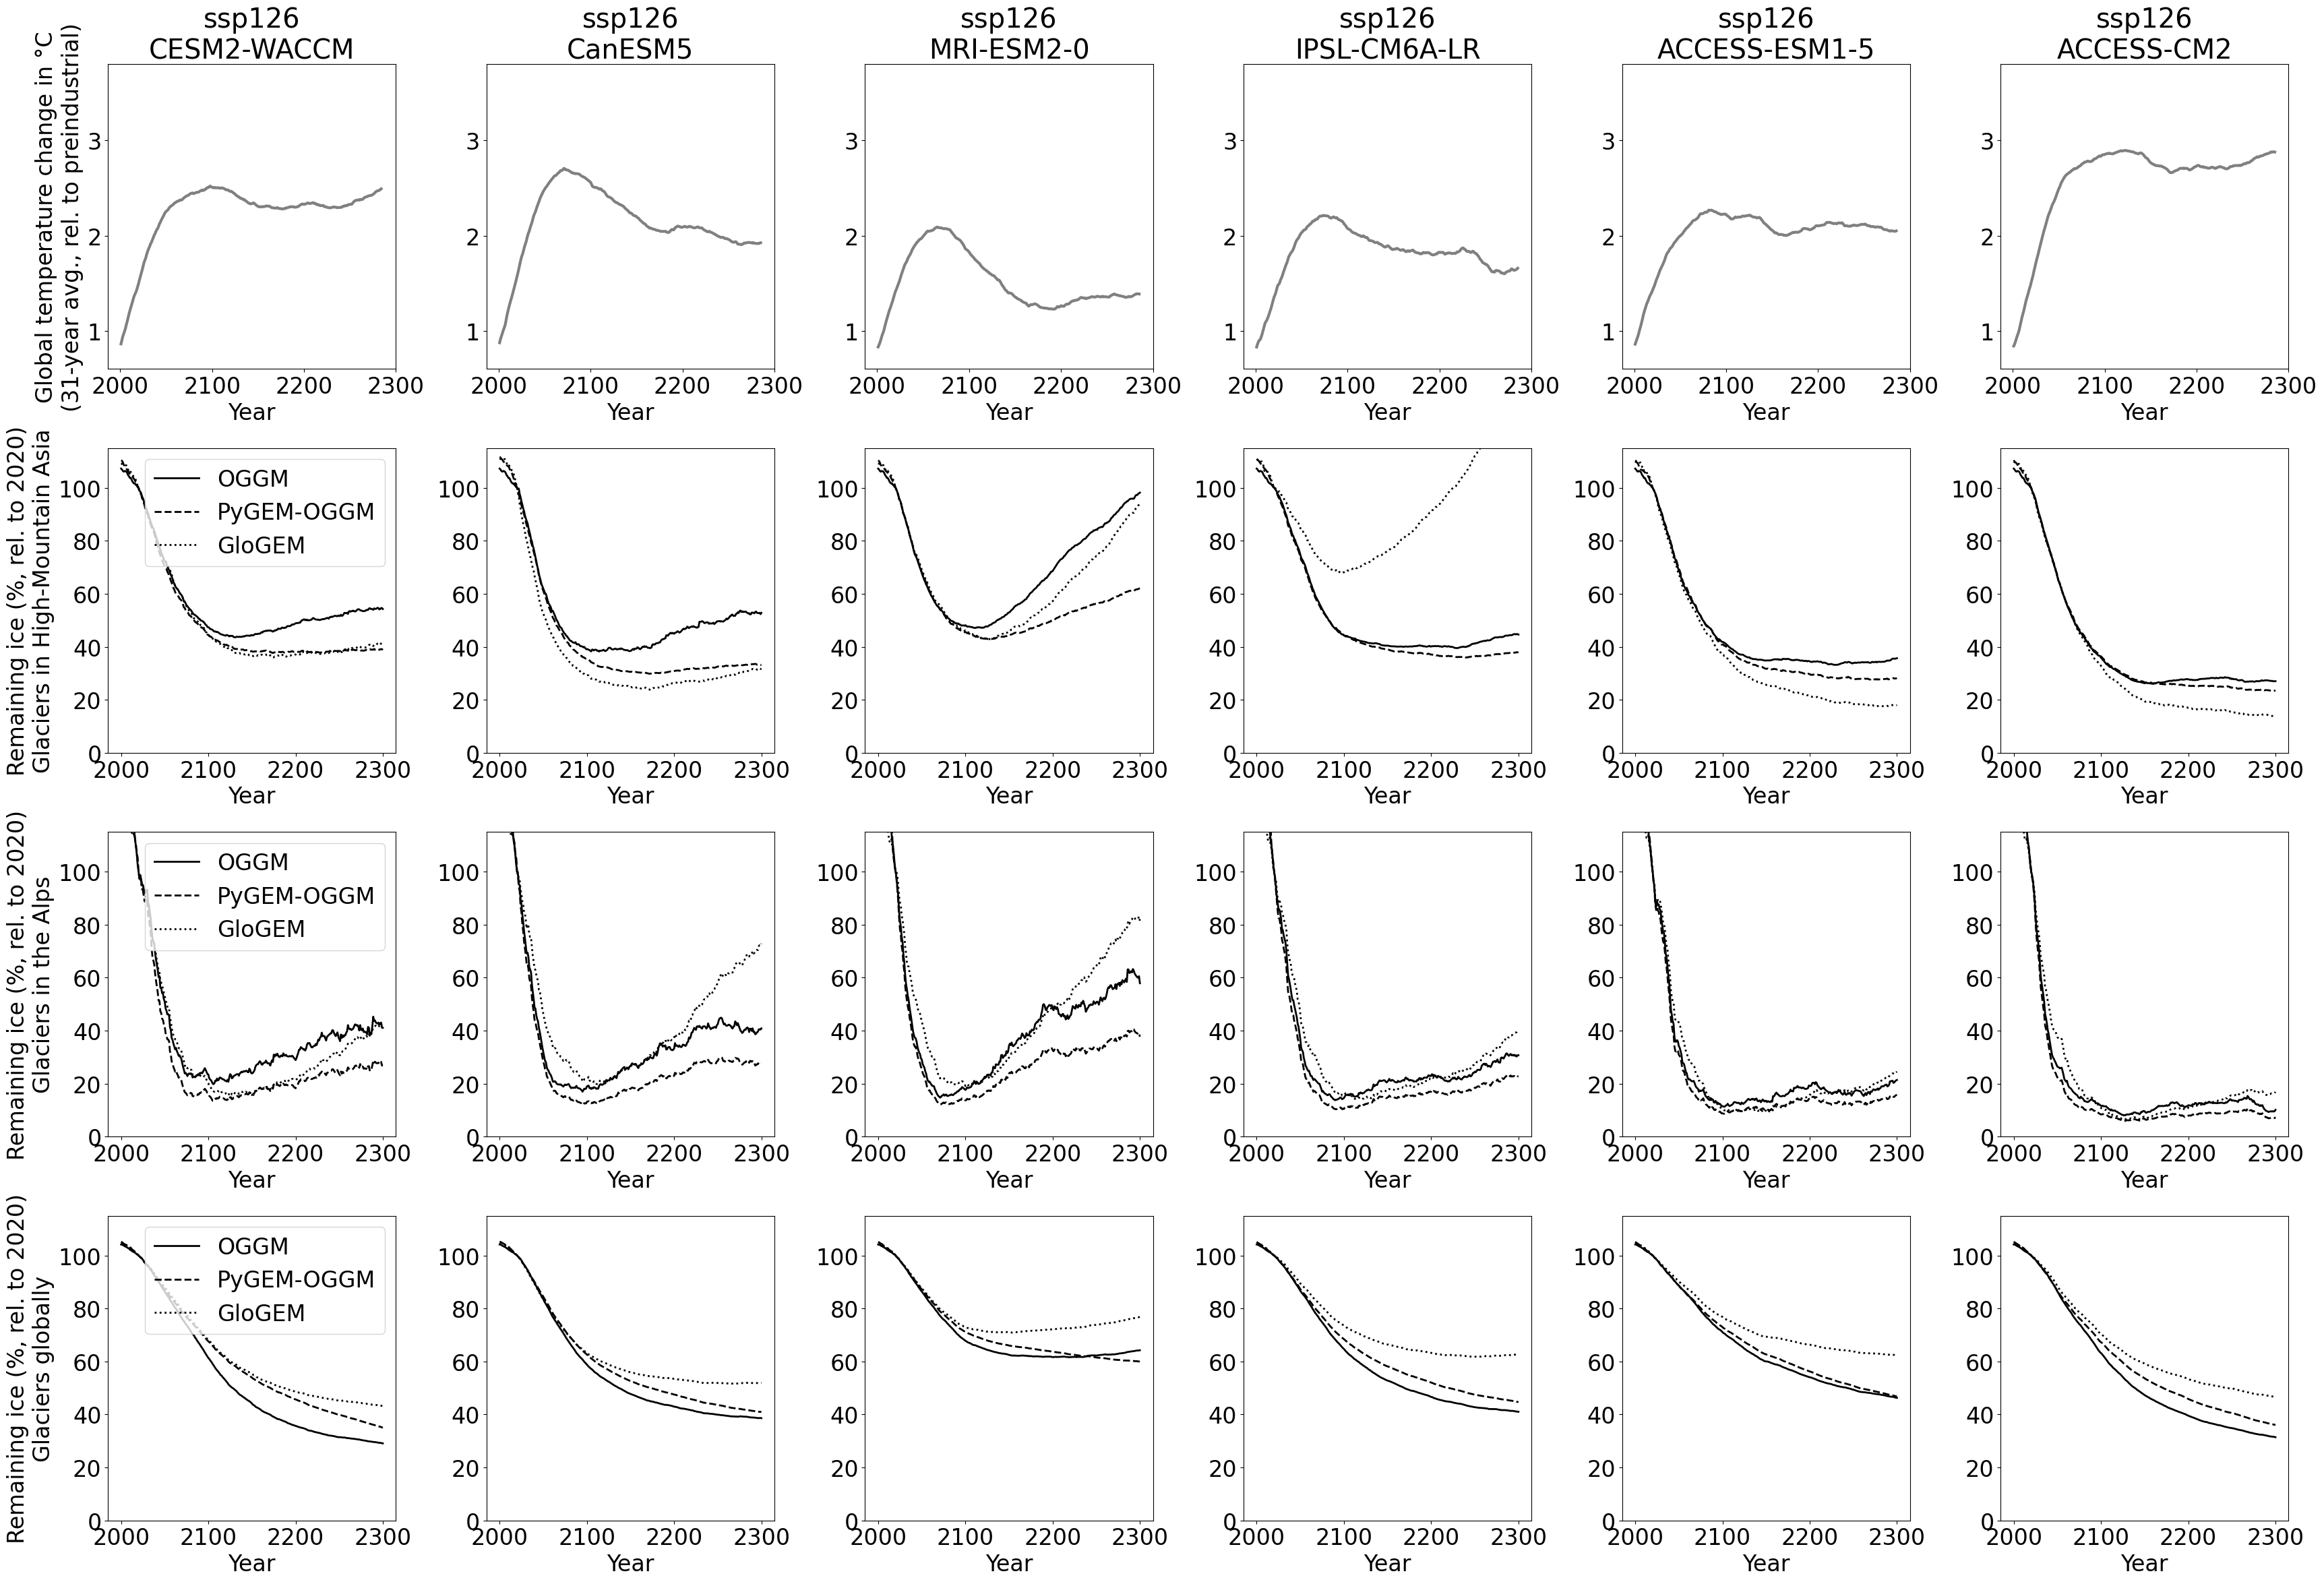

In [12]:

#fig,axs = plt.subplots(2,3,figsize=(24,20))
fig, axs_all = plt.subplots(4,6, figsize=(35,24))

axs = axs_all[0]
plt.rc('font', size=24)

# 'SSP5-3.4-over'

gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]

ssp = 'ssp126'
scenario = ssp
gcms_cmip6_2300_ssp = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]

#gcm_order = ['CESM2-WACCM', 'CanESM5','MRI-ESM2-0','IPSL-CM6A-LR']
gcm_order = [#'CESM2-WACCM', no overshoot
             'CanESM5',
       'MRI-ESM2-0', 
    #'IPSL-CM6A-LR', 'ACCESS-ESM1-5', 'ACCESS-CM2' ### no overshoot
            ]

gcm_order = ['CESM2-WACCM', #no overshoot
             'CanESM5',
       'MRI-ESM2-0', 
    'IPSL-CM6A-LR', 'ACCESS-ESM1-5', 'ACCESS-CM2' ### no overshoot
            ]

gcms_cmip6_2300_ssp.index = gcms_cmip6_2300_ssp.gcm
gcms_cmip6_2300_ssp = gcms_cmip6_2300_ssp.loc[gcm_order]

print(ssp, len(gcms_cmip6_2300_ssp))

for ax,f in zip(axs,gcms_cmip6_2300_ssp.index):
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_ssp.loc[f]['path'],
                                  use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

    weight = np.cos(np.deg2rad(dtas_annual.lat))
    weight = weight / weight.sum()
    global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
    avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
    avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
    temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + 0.69

    # get the global means for every month:
    global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=31, center=True).mean()
    #color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

    ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + 0.69, 
            color= 'grey', lw=3)
    gcm = gcms_cmip6_2300_ssp.loc[f].gcm
    ax.set_title(ssp+'\n'+gcm)
    ax.set_ylim([0.6,3.8])
    if ax == axs[0]:
        ax.set_ylabel('Global temperature change in °C\n(31-year avg., rel. to preindustrial)')
    ax.set_xlabel('Year')
    ax.set_xticks([2000,2100,2200,2300])
    overshoot_deg = global_dtas.max()- global_dtas.dropna(dim='year').isel(year=-1)
    print(gcm, overshoot_deg.values.round(1), '°C')
for region in ['global', 'RGI13-14-15', 'RGI11']:
    if region == 'global':
        axs = axs_all[3]
    elif region == 'RGI13-14-15':
        axs = axs_all[1]
    elif region == 'RGI11':
        axs = axs_all[2]
    for model in ['OGGM','PyGEM-OGGM','GloGEM']:
        #if model in ['PyGEM-OGGM','GloGEM']:
        _fpath_other_gmodels = '/home/users/lschuster/glacier-model-projections-until2300/glacier_model_csv_files'
        if region != 'RGI13-14-15':
            fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{region}/{scenario}.csv'
            #else:
            #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
            pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
            pd_cmip_scen = pd_cmip_scen.dropna()
        else:
            pd_cmip_scen = 0
            for sub_region in ['RGI13', 'RGI14', 'RGI15']: 
                fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{sub_region}/{scenario}.csv'
                #else:
                #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
                _pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
                _pd_cmip_scen = _pd_cmip_scen.dropna()
                _pd_cmip_scen.columns = [c.upper() for c in _pd_cmip_scen.columns]
                pd_cmip_scen += _pd_cmip_scen

        pd_cmip_scen.columns = [c.upper() for c in pd_cmip_scen.columns]
        for gcm,ax in zip(gcm_order,axs):
            ax.plot(pd_cmip_scen.loc[2000:2300].index, 100*pd_cmip_scen.loc[2000:2300][gcm.upper()]/pd_cmip_scen.loc[2020][gcm.upper()],
                     ls = model_ls[model], color='black',
                     label=model, lw=2)
        axs[0].legend()
        if region == 'global':
            region_n = 'Glaciers globally'
        elif region == 'RGI13-14-15':
            region_n = 'Glaciers in High-Mountain Asia'
        elif region == 'RGI11':
            region_n = 'Glaciers in the Alps'

        for ax in axs:
            if ax == axs[0]:
                ax.set_ylabel(f'Remaining ice (%, rel. to 2020)\n{region_n}')
            ax.set_xlabel('Year')
            ax.set_ylim([0,115])
            ax.set_xticks([2000,2100,2200,2300])

plt.tight_layout()
plt.savefig(f'figures/4_discussion_{ssp}_2300.png')

#### Absolute values graph ... 

ssp534-over 4


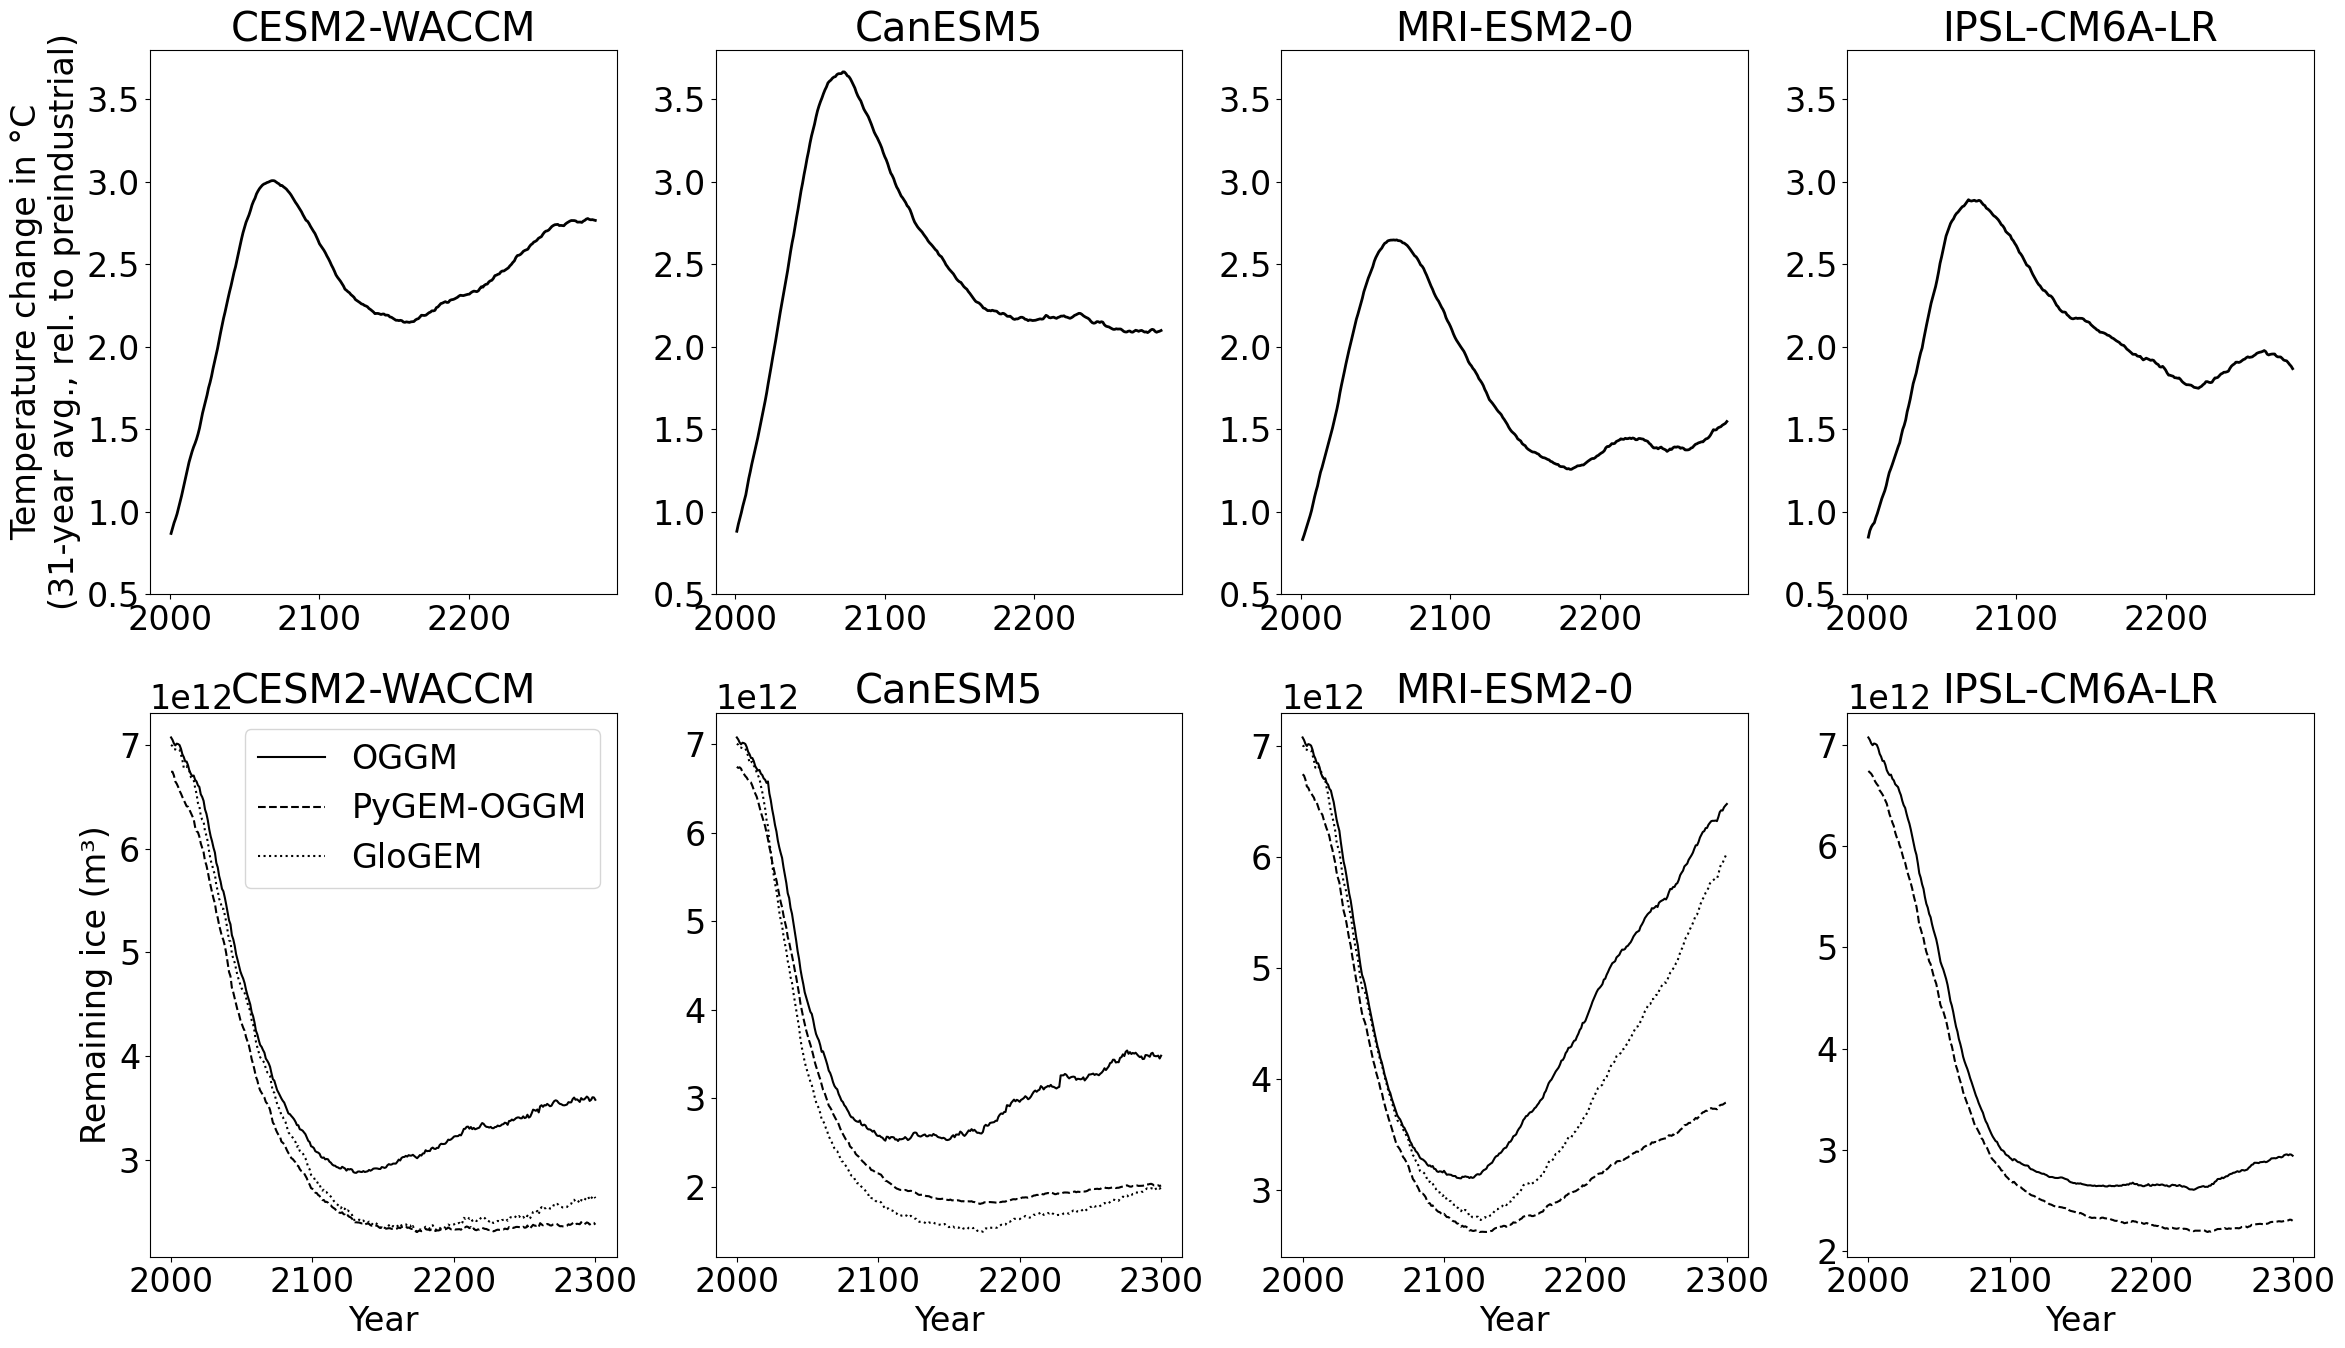

In [13]:

from matplotlib.lines import Line2D

#fig,axs = plt.subplots(2,3,figsize=(24,20))
fig, axs_all = plt.subplots(2,4, figsize=(24,14))

axs = axs_all[0]
plt.rc('font', size=24)
ssp = 'ssp534-over'
# 'SSP5-3.4-over'

gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]
gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]

gcm_order = ['CESM2-WACCM', 'CanESM5','MRI-ESM2-0','IPSL-CM6A-LR']
gcms_cmip6_2300_over.index = gcms_cmip6_2300_over.gcm
gcms_cmip6_2300_over = gcms_cmip6_2300_over.loc[gcm_order]

print(ssp, len(gcms_cmip6_2300_over))

for ax,f in zip(axs,gcms_cmip6_2300_over.index):
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                  use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

    weight = np.cos(np.deg2rad(dtas_annual.lat))
    weight = weight / weight.sum()
    global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
    avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
    avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
    temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + 0.69

    # get the global means for every month:
    global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=31, center=True).mean()
    #color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

    ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + 0.69, lw=2,
            color= 'black')
    gcm = gcms_cmip6_2300_over.loc[f].gcm
    ax.set_title(gcm)
    ax.set_ylim([0.5,3.8])
    if ax == axs[0]:
        ax.set_ylabel('Temperature change in °C\n(31-year avg., rel. to preindustrial)')
for region in ['RGI13-14-15']:
    if region == 'global':
        axs = axs_all[2]
    else:
        axs = axs_all[1]
    for model in ['OGGM','PyGEM-OGGM','GloGEM']:
        #if model in ['PyGEM-OGGM','GloGEM']:
        _fpath_other_gmodels = '/home/users/lschuster/glacier-model-projections-until2300/glacier_model_csv_files'
        if region != 'RGI13-14-15':
            fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{region}/{scenario}.csv'
            #else:
            #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
            pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
            pd_cmip_scen = pd_cmip_scen.dropna()
            pd_cmip_scen.columns = [c.upper() for c in pd_cmip_scen.columns]

        else:
            pd_cmip_scen = 0
            for sub_region in ['RGI13', 'RGI14', 'RGI15']: 
                fpath_gmodels = f'{_fpath_other_gmodels}/{model}/volume/{cmip}/{endyr}/{sub_region}/{scenario}.csv'
                #else:
                #fpath_gmodels = f'{fpath}/{cmip}/{endyr}/global/{scenario}.csv'
                _pd_cmip_scen = pd.read_csv(fpath_gmodels, index_col=0)
                _pd_cmip_scen = _pd_cmip_scen.dropna()
                _pd_cmip_scen.columns = [c.upper() for c in _pd_cmip_scen.columns]
                pd_cmip_scen += _pd_cmip_scen

        axs[0].plot(pd_cmip_scen.loc[2000:2300].index, pd_cmip_scen.loc[2000:2300]['CESM2-WACCM'], ls = model_ls[model], color='black',
                   label=model)
        axs[0].set_title('CESM2-WACCM')
        axs[1].plot(pd_cmip_scen.loc[2000:2300].index, pd_cmip_scen.loc[2000:2300]['CANESM5'], ls = model_ls[model], color='black')
        axs[1].set_title('CanESM5')
        axs[2].plot(pd_cmip_scen.loc[2000:2300].index, pd_cmip_scen.loc[2000:2300]['MRI-ESM2-0'], ls = model_ls[model], color='black')
        axs[2].set_title('MRI-ESM2-0')
        if model != 'GloGEM':
            axs[3].plot(pd_cmip_scen.loc[2000:2300].index, pd_cmip_scen.loc[2000:2300]['IPSL-CM6A-LR'], ls = model_ls[model], color='black')
            axs[3].set_title('IPSL-CM6A-LR')
        axs[0].legend()
        for ax in axs:
            if ax == axs[0]:
                ax.set_ylabel('Remaining ice (m³)')
            ax.set_xlabel('Year')
            #ax.set_ylim([0,135])

plt.tight_layout()

In [14]:
pd_cmip_scen

ACCESS-CM2  ACCESS-ESM1-5   CESM2-WACCM       CANESM5  IPSL-CM6A-LR  \
time                                                                            
1980.0  7.000443e+12   7.000443e+12  7.000443e+12  7.000443e+12  7.000443e+12   
1981.0  7.000443e+12   7.000443e+12  7.000443e+12  7.000443e+12  7.000443e+12   
1982.0  7.000443e+12   7.000443e+12  7.000443e+12  7.000443e+12  7.000443e+12   
1983.0  7.000443e+12   7.000443e+12  7.000443e+12  7.000443e+12  7.000443e+12   
1984.0  7.000443e+12   7.000443e+12  7.000443e+12  7.000443e+12  7.000443e+12   
...              ...            ...           ...           ...           ...   
2296.0  8.856151e+11   1.145370e+12  2.611755e+12  1.977860e+12  8.685634e+12   
2297.0  8.858643e+11   1.140253e+12  2.627601e+12  1.986557e+12  8.711772e+12   
2298.0  8.835950e+11   1.137834e+12  2.643073e+12  1.999165e+12  8.755755e+12   
2299.0  8.825589e+11   1.136357e+12  2.654976e+12  1.981836e+12  8.788789e+12   
2300.0  8.807416e+11   1.141143e+12  2.629942e+12  1.997052e+12  8.810187e+12   

          MRI-ESM2-0  
time                  
1980.0  7.000443e+12  
1981.0  7.000443e+12  
1982.0  7.000443e+12  
1983.0  7.000443e+12  
1984.0  7.000443e+12  
...              ...  
2296.0  5.933248e+12  
2297.0  5.942168e+12  
2298.0  5.975800e+12  
2299.0  6.003916e+12  
2300.0  6.029123e+12  

[321 rows x 6 columns]